In [1]:
import umap
import numpy as np
import numpy.linalg as la
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
%notebook

UsageError: the following arguments are required: filename


In [8]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


In [9]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [ ]:
%NotebookApp.iopub_data_rate_limit=1.0e10

## Control embedding 
The following embedding represents the control embedding for the fashion MNIST. rotational invariance over this data would translate to a perfect rotation across the entire embedding. For now all embedding will be done in two dimensions to expedite embedding comparison 


In [12]:
neighbors=15
dim=2
epochs=500
dist=.2

In [5]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_2d = reducer.fit_transform(data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Tue Sep  6 08:54:02 2022 Construct fuzzy simplicial set
Tue Sep  6 08:54:02 2022 Finding Nearest Neighbors
Tue Sep  6 08:54:02 2022 Building RP forest with 18 trees
Tue Sep  6 08:54:03 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue Sep  6 08:54:15 2022 Finished Nearest Neighbor Search
Tue Sep  6 08:54:17 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Sep  6 08:56:06 2022 Finished embedding


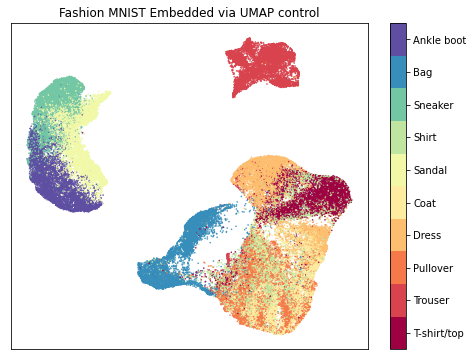

In [7]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

In [5]:
def rotate(angle,image):
    # Define the most occuring variables
    angle=math.radians(angle)                               #converting degrees to radians
    cosine=math.cos(angle)
    sine=math.sin(angle)
    height=image.shape[0]                                   #define the height of the image
    width=image.shape[1]                                    #define the width of the image
    
    # Define the height and width of the new image that is to be formed
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    # define another image variable of dimensions of new_height and new _column filled with zeros
    output=np.zeros((new_height,new_width))
    print(output.shape)
    # Find the centre of the image about which we have to rotate the image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(angle,x,y)

            '''since image will be rotated the centre will change too, 
                so to adust to that we will need to change new_x and new_y with respect to the new centre'''
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    """
    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width                      

            #co-ordinate of pixel with respect to the rotated image
            new_y=round(-x*sine+y*cosine)
            
            new_x=round(x*cosine+y*sine)

            '''since image will be rotated the centre will change too, 
               so to adust to that we will need to change new_x and new_y with respect to the new centre'''
            
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            # adding if check to prevent any errors in the processing
            if 0 <= new_x < new_width and 0 <= new_y < new_height and new_x>=0 and new_y>=0:
                output[new_y,new_x]=image[i,j]
    """
    
    return output           

In [6]:
# sheering the data in a special way here ensures that there are not problems with anti alising 
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    # shear 1
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    #shear 2
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix

    #shear 3
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

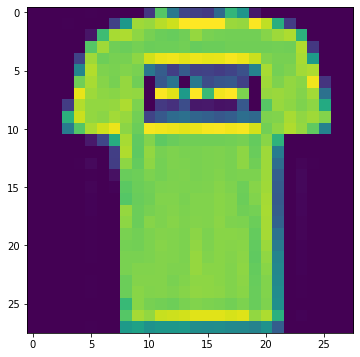

(41, 41)
(28, 28)
16.216296548252593
(41, 41)
<class 'numpy.ndarray'>


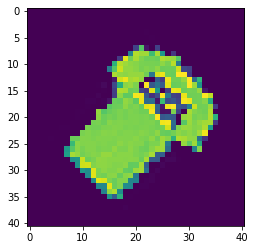

In [84]:
l=np.reshape(data[1],(28,28))
fig = plt.figure( figsize=(8, 6))
plt.imshow(l, cmap='viridis')
plt.show()

#fails for 5,6 degrees
i=rotate(45,l)
print(i.shape)

print(type(i))
plt.imshow(i, cmap='viridis')
plt.show()


In [11]:
#rotating all of the data by 45deg
theta=45
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r45_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r45_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 99.8%
(41, 41)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r45 = reducer.fit_transform(r45_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Tue Sep  6 10:11:41 2022 Construct fuzzy simplicial set
Tue Sep  6 10:11:41 2022 Finding Nearest Neighbors
Tue Sep  6 10:11:41 2022 Building RP forest with 18 trees
Tue Sep  6 10:11:43 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue Sep  6 10:11:46 2022 Finished Nearest Neighbor Search
Tue Sep  6 10:11:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Sep  6 10:13:35 2022 Finished embedding


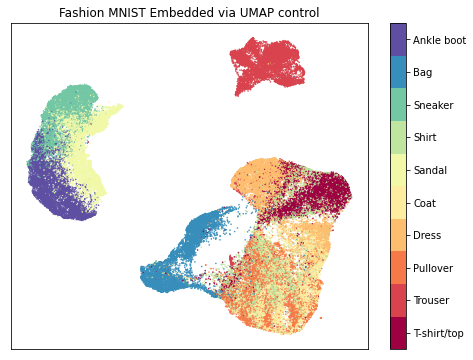

In [17]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_r45.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');